# 安装DeepChem

In [ ]:
#!pip install --pre deepchem
import deepchem
deepchem.__version__

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a

'2.8.1.dev'

# 导入工具包

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import deepchem as dc
import deepchem.models
import torch
from deepchem.models.torch_models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
from torch.nn.functional import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

# 导入SMIELS数据（用于建模）

In [3]:
# Download from MolNet
# Try tox21 or LIPO dataset
#tasks, datasets, transformers = dc.molnet.load_tox21()
#df = pd.DataFrame(data={'smiles': datasets[0].ids})
df = pd.read_csv('tox21.tsv', sep='\t', index_col=0)
df.head(2)

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C


# 对分子数据进行特征化（featurization）

In [4]:
num_atoms = 12

In [5]:
#data = df[['smiles']].sample(4000, random_state=42)
data = df

In [6]:
# create featurizer
feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms, atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14]) #15, 16, 17, 19, 20, 24, 29, 35, 53, 80])

In [7]:
smiles = data['smiles'].values

In [8]:
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]

[15:40:04] WARNING: not removing hydrogen atom without neighbors


In [9]:
# featurize molecules
features = feat.featurize(filtered_smiles)

Failed to featurize datapoint 0, CC(O)(P(=O)(O)O)P(=O)(O)O. Appending empty array
Exception message: 15
Failed to featurize datapoint 11, O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ca+2]. Appending empty array
Exception message: 20
[15:40:04] WARNING: not removing hydrogen atom without neighbors
Failed to featurize datapoint 12, F[B-](F)(F)F.[H+]. Appending empty array
Exception message: 1
Failed to featurize datapoint 14, [I-].[K+]. Appending empty array
Exception message: 19
Failed to featurize datapoint 17, C=CC(=O)OCCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 25, ClCOCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 27, [Cu]I. Appending empty array
Exception message: 29
Failed to featurize datapoint 32, BrCBr. Appending empty array
Exception message: 35
Failed to featurize datapoint 33, CCC(Cl)CCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 39, NC(=S)NNC(N)=S. Appending empty array
Exception mess

In [10]:
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ]
print(indices)
features = [features[i] for i in indices]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 34, 35, 36, 37, 38, 43, 46, 47, 48, 50, 51, 52, 53, 56, 58, 59, 60, 62, 63, 64, 65, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 83, 84, 85, 86, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 109, 110, 111, 112, 113, 114, 115, 119, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 143, 144, 145, 149, 150, 157, 159, 164, 165, 169, 170, 171, 172, 173, 174, 176, 177, 179, 181, 182, 184, 186, 188, 189, 191, 192, 196, 197, 198, 199, 202, 205, 206, 207, 208, 209, 213, 215, 216, 219, 220, 221, 222, 225, 226, 227, 229, 231, 232, 233, 234, 235, 236, 237, 239, 240, 244, 247, 248, 249, 252, 254, 255, 256, 257, 258, 261, 262, 264, 265, 266, 268, 269, 270, 273, 274, 275, 277, 278, 280, 283, 285, 286, 287, 288, 289, 292, 296, 297, 298, 299, 300, 301, 302, 303, 304, 306, 307, 308, 309, 312, 313, 314, 315, 317, 318, 319, 322, 323, 324, 325, 326, 327, 328, 329, 33

# 初始化模型，设置学习率

In [19]:
# create model
# ExponentialDecay(0.001, 0.9, 5000)
learning_rate = ExponentialDecay(0.001, 0.90, 10000)
gan = MolGAN(learning_rate=learning_rate, vertices=num_atoms)
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

In [12]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            flattened_adjacency = torch.from_numpy(batch[0]).view(-1).to(dtype=torch.int64) # flatten the input because torch.nn.functional.one_hot only works with 1D inputs
            invalid_mask = (flattened_adjacency < 0) | (flattened_adjacency >= gan.edges) # edge type cannot be negative or >= gan.edges, these entries are invalid
            clamped_adjacency = torch.clamp(flattened_adjacency, 0, gan.edges-1) # clamp the input so it can be fed to the one_hot function
            adjacency_tensor = one_hot(clamped_adjacency, num_classes=gan.edges) # actual one_hot
            adjacency_tensor[invalid_mask] = torch.zeros(gan.edges, dtype=torch.long) # make the invalid entries, a vector of zeros
            adjacency_tensor = adjacency_tensor.view(*batch[0].shape, -1) # reshape to original shape and change dtype for stability.

            flattened_node = torch.from_numpy(batch[1]).view(-1).to(dtype=torch.int64)
            invalid_mask = (flattened_node < 0) | (flattened_node >= gan.nodes)
            clamped_node = torch.clamp(flattened_node, 0, gan.nodes-1)
            node_tensor = one_hot(clamped_node, num_classes=gan.nodes)
            node_tensor[invalid_mask] = torch.zeros(gan.nodes, dtype=torch.long)
            node_tensor = node_tensor.view(*batch[1].shape, -1)

            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

# 模型训练并生成分子

In [20]:
gan.fit_gan(iterbatches(200), generator_steps=0.25, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(1000)

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ending global_step 2799: generator average loss -27.6403, discriminator average loss -16.6134
TIMING: model fitting took 36.997 s
Generating 1000 samples


In [21]:
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


[15:43:42] Explicit valence for atom # 0 C, 8, is greater than permitted
[15:43:42] Explicit valence for atom # 2 O, 21, is greater than permitted
[15:43:42] Explicit valence for atom # 1 O, 3, is greater than permitted
[15:43:42] Explicit valence for atom # 2 C, 19, is greater than permitted
[15:43:42] Explicit valence for atom # 0 O, 17, is greater than permitted
[15:43:42] Explicit valence for atom # 0 C, 20, is greater than permitted
[15:43:42] Explicit valence for atom # 0 B, 20, is greater than permitted
[15:43:42] Explicit valence for atom # 0 B, 22, is greater than permitted
[15:43:42] Explicit valence for atom # 0 B, 5, is greater than permitted
[15:43:42] Explicit valence for atom # 0 C, 23, is greater than permitted
[15:43:42] Explicit valence for atom # 1 C, 11, is greater than permitted


# 分子有效性检查

In [22]:
nmols = list(filter(lambda x: x is not None, nmols))

In [23]:
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

664 valid molecules


In [24]:
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
print ("{} unique valid molecules".format(len(nmols_viz)))

45 unique valid molecules


# 分子可视化

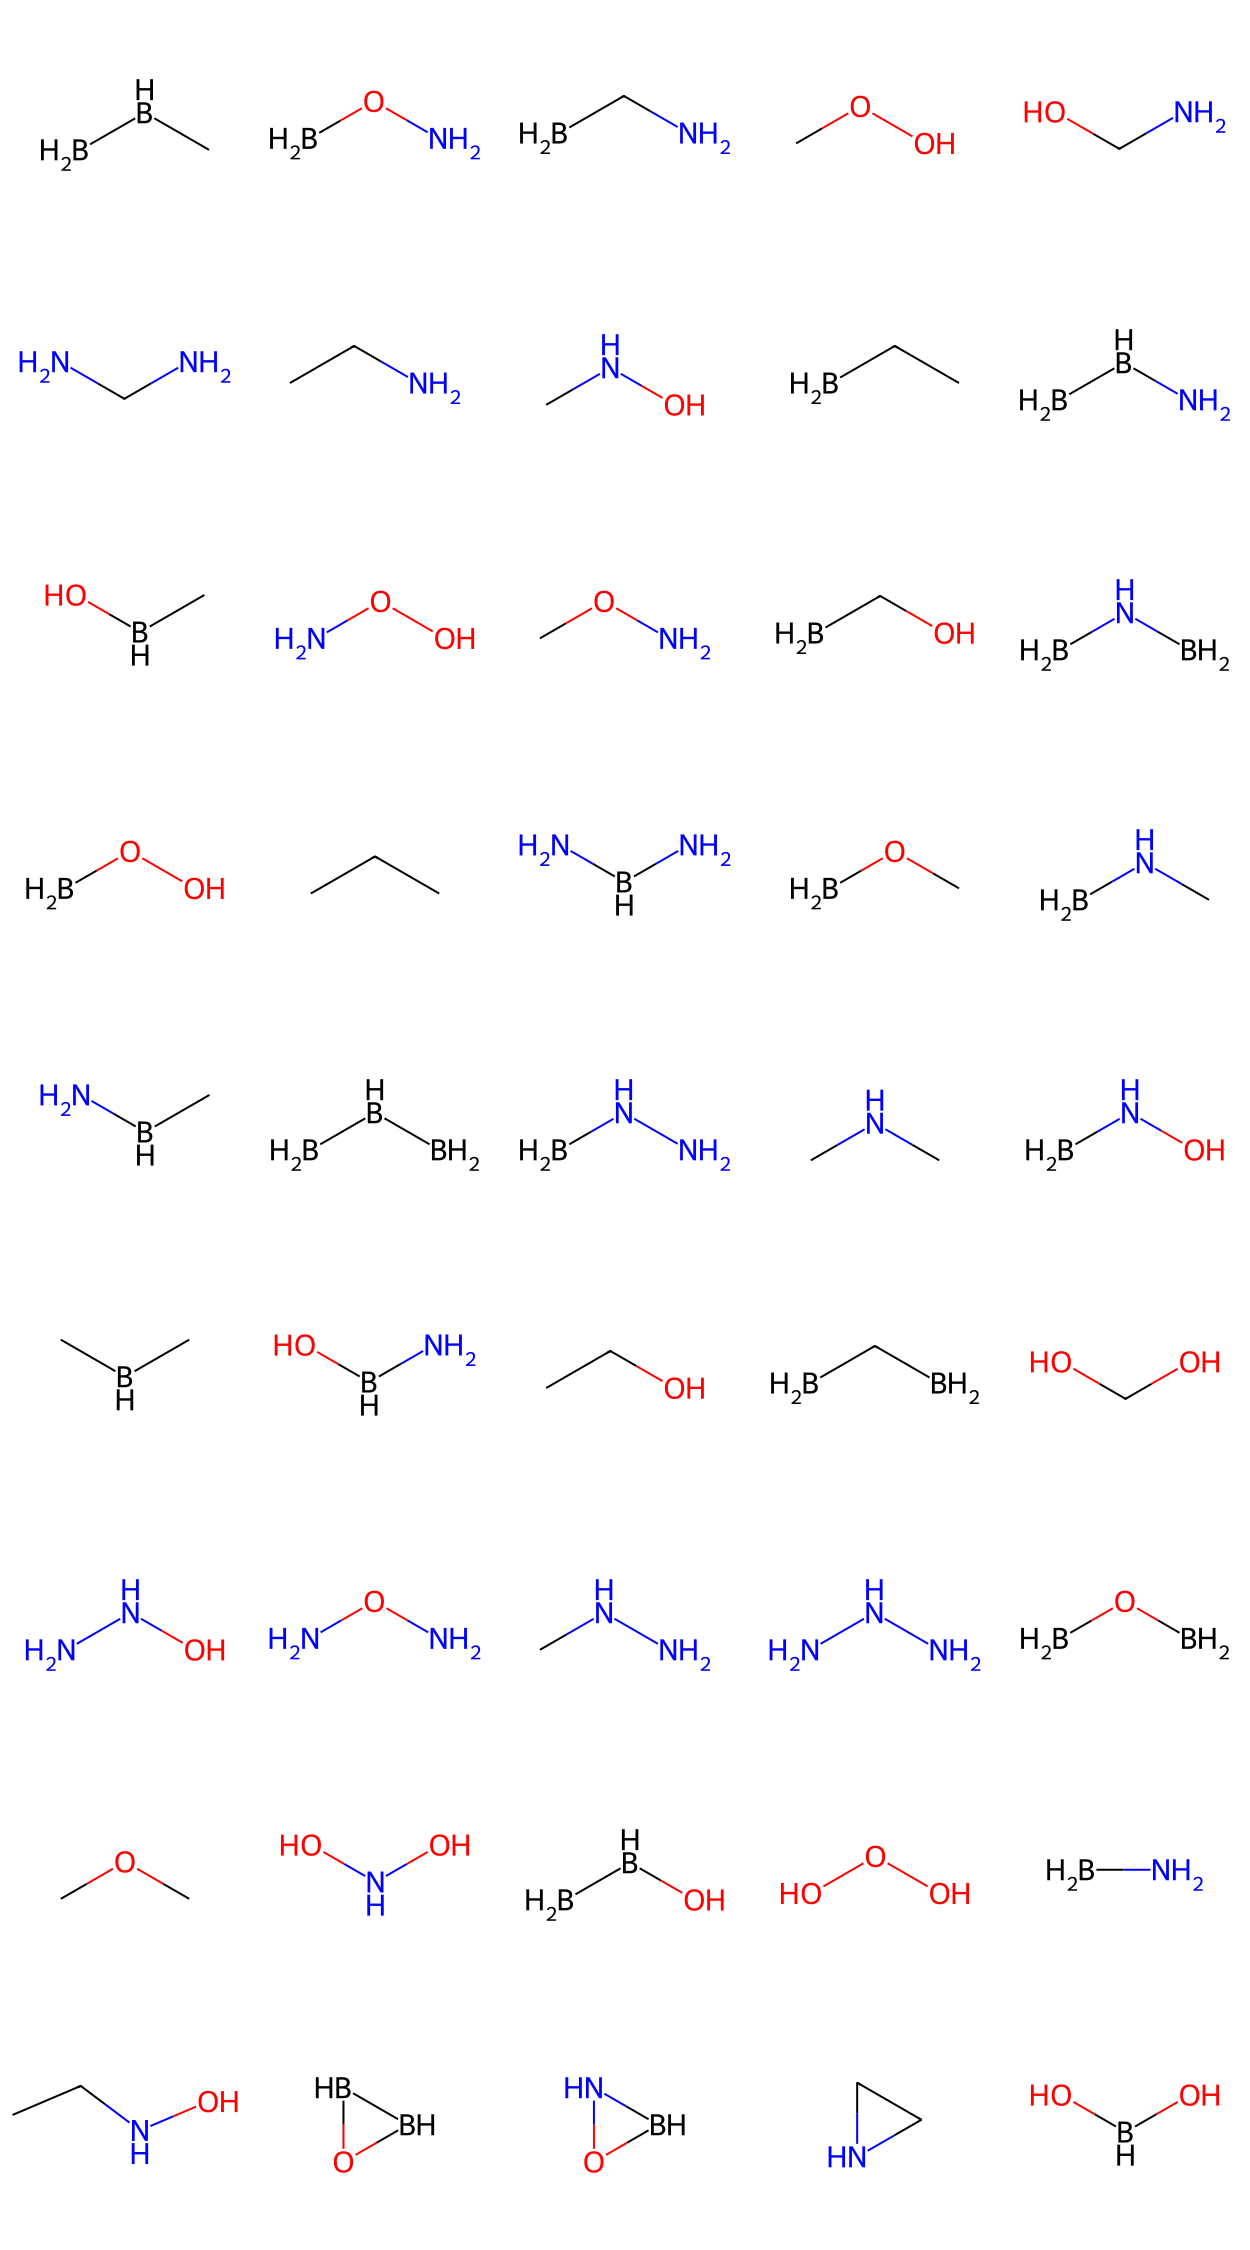

In [25]:
Draw.MolsToGridImage(nmols_viz[0:100], molsPerRow=5, subImgSize=(250, 250), maxMols=100, legends=None, returnPNG=False)